# 3. Pretrained convnets

Here I will be using VGG16 net trained on ImageNet which comes with Keras. I will reuse the convolutional base while retraining the dense classifier to clasify cat and dog dataset from section 2.

In [14]:
from keras.applications import VGG16
import keras

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))
print(f"VGG16 convolutional base outputs a {conv_base.output_shape} tensor.")


VGG16 convolutional base outputs a (None, 4, 4, 512) tensor.


We could run the convolutional base over the avilable data once and store the results. After that we can train the dense layers over those results. This is faster but we cannot use data augmentation.

We can extend the model with dense layers and run the whole thing. This is much more expensive but supports data augmentation. 

## First method: run conv base once

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
import matplotlib.pyplot as plt

In [4]:
base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    print(f"Extracting features from {sample_count} samples in {directory}.")
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                                            directory,
                                            target_size=(150,150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        print(f"{i * batch_size }/{sample_count}")
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Extracting features from 2000 samples in ./datasets/cats_and_dogs_small/train.
Found 2000 images belonging to 2 classes.
0/2000
20/2000
40/2000
60/2000
80/2000
100/2000
120/2000
140/2000
160/2000
180/2000
200/2000
220/2000
240/2000
260/2000
280/2000
300/2000
320/2000
340/2000
360/2000
380/2000
400/2000
420/2000
440/2000
460/2000
480/2000
500/2000
520/2000
540/2000
560/2000
580/2000
600/2000
620/2000
640/2000
660/2000
680/2000
700/2000
720/2000
740/2000
760/2000
780/2000
800/2000
820/2000
840/2000
860/2000
880/2000
900/2000
920/2000
940/2000
960/2000
980/2000
1000/2000
1020/2000
1040/2000
1060/2000
1080/2000
1100/2000
1120/2000
1140/2000
1160/2000
1180/2000
1200/2000
1220/2000
1240/2000
1260/2000
1280/2000
1300/2000
1320/2000
1340/2000
1360/2000
1380/2000
1400/2000
1420/2000
1440/2000
1460/2000
1480/2000
1500/2000
1520/2000
1540/2000
1560/2000
1580/2000
1600/2000
1620/2000
1640/2000
1660/2000
1680/2000
1700/2000
1720/2000
1740/2000
1760/2000
1780/2000
1800/2000
1820/2000
1840/2000
1860/

In [5]:
# Flatten features.
train_features = train_features.reshape((2000, 4 * 4 * 512))
validation_features = validation_features.reshape((1000, 4 * 4 * 512))
test_features = test_features.reshape((1000, 4 * 4 * 512))

In [6]:
# Define the classifier.
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 562us/step - loss: 0.6326 - acc: 0.6400 - val_loss: 0.4563 - val_acc: 0.8230
Epoch 2/30
2000/2000 [==============================] - 1s 288us/step - loss: 0.4374 - acc: 0.8005 - val_loss: 0.3672 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 1s 288us/step - loss: 0.3635 - acc: 0.8400 - val_loss: 0.3291 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 1s 287us/step - loss: 0.3134 - acc: 0.8715 - val_loss: 0.3142 - val_acc: 0.8760
Epoch 5/30
2000/2000 [==============================] - 1s 288us/step - loss: 0.2929 - acc: 0.8825 - val_loss: 0.2890 - val_acc: 0.8860
Epoch 6/30
2000/2000 [==============================] - 1s 286us/step - loss: 0.2742 - acc: 0.8940 - val_loss: 0.2793 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 1s 288us/step - loss: 0.2505 - acc: 0.9040 - val_loss: 0.2850 - val_acc: 0.8790


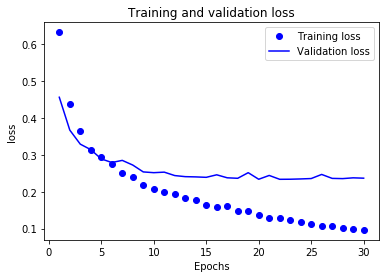

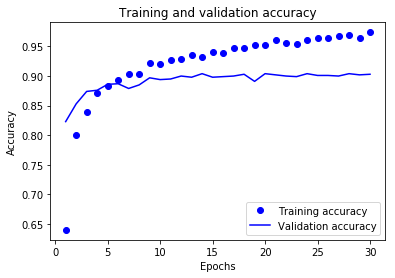

In [7]:
def plot_history(history):
    def plot_history_record(history, record, *args, **kwargs):
        values = history.history[record]
        epochs = range(1, len(values) + 1)
        plt.plot(epochs, values, *args, **kwargs)

    plot_history_record(history, 'loss', 'bo', label='Training loss')
    plot_history_record(history, 'val_loss', 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.figure()
    plot_history_record(history, 'acc', 'bo', label='Training accuracy')
    plot_history_record(history, 'val_acc', 'b', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
plot_history(history)

We can see that we are achiveing great results but also significantly overfitting the training data. This is because we are not using data augmentation with a small image dataset.

# Feature extraction with data augmentation
Here we will extend the base with a classifier.

**This will probably be intractable on a CPU. Ensure you have a GPU to run this code.**

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Freeze the base.
conv_base.trainable = True
print(f"Number of paramters before freezing the base:{len(model.trainable_weights)} ")
conv_base.trainable = False
print(f"Number of paramters after freezing the base:{len(model.trainable_weights)} ")

Number of paramters before freezing the base:30 
Number of paramters after freezing the base:4 


In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150), 
                                                        batch_size=20, 
                                                        class_mode='binary')
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30, 
                              validation_data=validation_generator,
                              validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 31s 307ms/step - loss: 0.6031 - acc: 0.6880 - val_loss: 0.4610 - val_acc: 0.8110
Epoch 2/30
100/100 [==============================] - 30s 303ms/step - loss: 0.4836 - acc: 0.7790 - val_loss: 0.3771 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 30s 303ms/step - loss: 0.4257 - acc: 0.8135 - val_loss: 0.3340 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 30s 304ms/step - loss: 0.4077 - acc: 0.8150 - val_loss: 0.3140 - val_acc: 0.8780
Epoch 5/30
100/100 [==============================] - 30s 303ms/step - loss: 0.3836 - acc: 0.8275 - val_loss: 0.2964 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 30s 303ms/step - loss: 0.3713 - acc: 0.8355 - val_loss: 0.3067 - val_acc: 0.8640
Epoch 7/30
100/100 [==============================] - 30s 304ms/step - loss: 0.3563 - acc: 0.8370 - val_lo

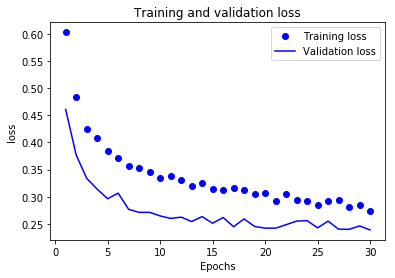

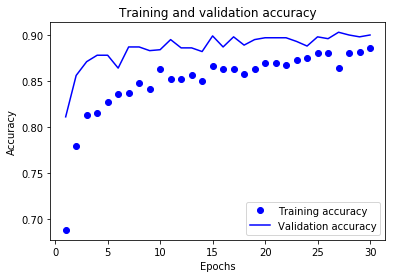

In [11]:
plot_history(history)

## Fine tuning method
In this method we unfreeze the last few layers of a frozen model base and train those layers along with the added Dense classifier. This can only be done once the clasiffier has already been trained. Otherwise the overly large error value will destroy the representation in the leyers underrgoing tuning.

In [12]:
# Unfreeze the last convolutional block.
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model_old = keras.models.clone_model(model)
model.compile(optimizers.RMSprop(lr=1e-5), loss = 'binary_crossentropy', metrics=['acc'] )
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 36s 362ms/step - loss: 0.2835 - acc: 0.8720 - val_loss: 0.2249 - val_acc: 0.9170
Epoch 2/100
100/100 [==============================] - 35s 350ms/step - loss: 0.2666 - acc: 0.8830 - val_loss: 0.2153 - val_acc: 0.9130
Epoch 3/100
100/100 [==============================] - 35s 350ms/step - loss: 0.2459 - acc: 0.8950 - val_loss: 0.2217 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 35s 351ms/step - loss: 0.2150 - acc: 0.9130 - val_loss: 0.2292 - val_acc: 0.9210
Epoch 5/100
100/100 [==============================] - 35s 351ms/step - loss: 0.2112 - acc: 0.9090 - val_loss: 0.1965 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 35s 350ms/step - loss: 0.1879 - acc: 0.9180 - val_loss: 0.1973 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 35s 350ms/step - loss: 0.1736 - acc: 0.9195 - val_loss: 0.2163 - val_acc: 0.9240
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 35s 351ms/step - loss: 0.0256 - acc: 0.9910 - val_loss: 0.3996 - val_acc: 0.9150
Epoch 62/100
100/100 [==============================] - 35s 351ms/step - loss: 0.0345 - acc: 0.9875 - val_loss: 0.2280 - val_acc: 0.9460
Epoch 63/100
100/100 [==============================] - 35s 351ms/step - loss: 0.0332 - acc: 0.9870 - val_loss: 0.3180 - val_acc: 0.9210
Epoch 64/100
100/100 [==============================] - 35s 351ms/step - loss: 0.0272 - acc: 0.9890 - val_loss: 0.2473 - val_acc: 0.9410
Epoch 65/100
100/100 [==============================] - 35s 351ms/step - loss: 0.0317 - acc: 0.9880 - val_loss: 0.2288 - val_acc: 0.9440
Epoch 66/100
100/100 [==============================] - 35s 351ms/step - loss: 0.0287 - acc: 0.9880 - val_loss: 0.2259 - val_acc: 0.9400
Epoch 67/100
100/100 [==============================] - 35s 351ms/step - loss: 0.0283 - acc: 0.9900 - val_loss: 0.2550 - val_acc: 0.9370
Epoch 68/100
100/100 [===================

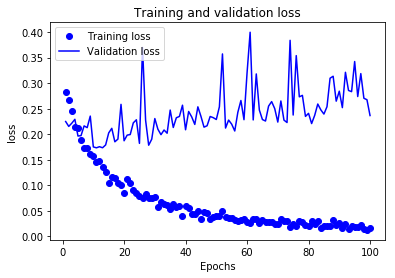

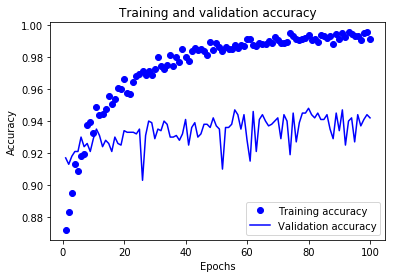

In [18]:
plot_history(history)

Use exponential moving average to smooth the plotted curves

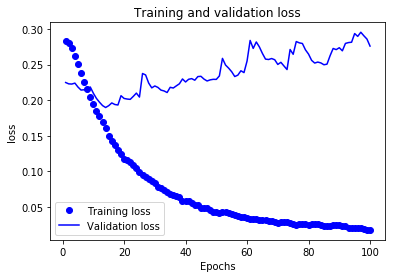

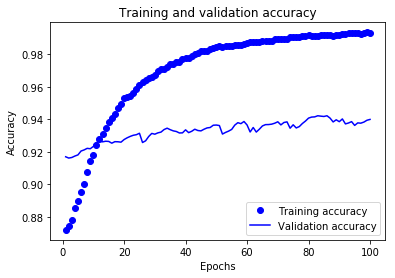

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(%precisionvious * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_history_smooth(history):
    def plot_history_record(history, record, *args, **kwargs):
        values = smooth_curve(history.history[record])
        epochs = range(1, len(values) + 1)
        plt.plot(epochs, values, *args, **kwargs)

    plot_history_record(history, 'loss', 'bo', label='Training loss')
    plot_history_record(history, 'val_loss', 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.figure()
    plot_history_record(history, 'acc', 'bo', label='Training accuracy')
    plot_history_record(history, 'val_acc', 'b', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
plot_history_smooth(history)

In [21]:
# Test on test dataset.
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator,steps=50)
print(f"Test accuracy: {test_acc}%")

Found 1000 images belonging to 2 classes.
Test accuracy: 0.9359999930858612%


In [22]:
model.save('cats_and_dogs_small_VGG16.h5')